# Laboratorium

### Konfiguracja

In [9]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from queue import Queue
from matplotlib.widgets import Button
import json as js



# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

%matplotlib notebook

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling=True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [10]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points = points
        self.lines = lines


# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points


# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes=[Scene()], points=[], lines=[], json=None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines": [linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

        # Metoda ta zwraca punkty dodane w trakcie rysowania.

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines + self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on=False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Funkcje pomocnicze

In [11]:
from copy import copy
# funkcja orienta zwraca wyznacznik macierzy postaci
#  | ax, ay, 1 |
#  | bx, by, 1 |
#  | cx, cy, 1 |
# wyznacznik ten definiuje po jakiej stronie (lewo / prawo)
# znajduje się punkt c względem wektora -ab->
def orient(a, b, c):
    return a[0] * b[1] + a[1] * c[0] + b[0] * c[1] - b[1] * c[0] - a[1] * b[0] - a[0] * c[1]


# maksymalna odległość między punktami, aby dwa punkty zostały uznane za jeden
EPS = 1e-9

## Wczytywanie zbioru odcinków od użytkownika

Wczytywanie odcinków odbywa się poprzez wczytanie odcinków z użyciem przycisku "Dodaj linię"
Zbiór odcinków musi być ogólny, tzn:
* 

<IPython.core.display.Javascript object>


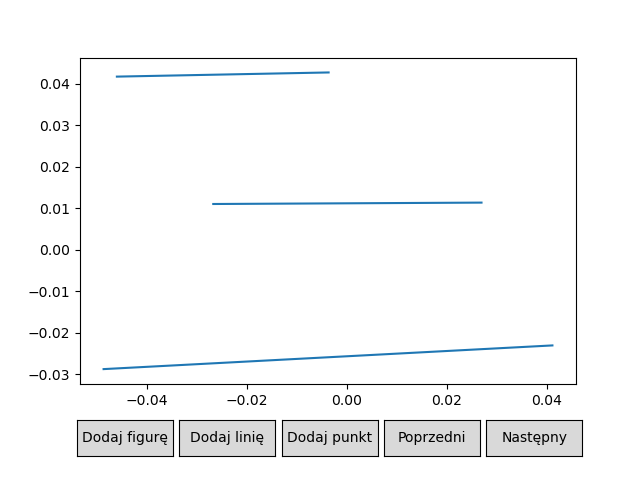

In [16]:
input_plot = Plot(scenes=[Scene()])
input_plot.draw()

In [17]:
# funkcja odpowiada za pobranie wczytanych odcinków z
# wykresu (Plot)
def get_input_lines(p):
    lines = []
    for collection in p.get_added_lines():
        for line in collection.lines:
            if line[0][0] < line[1][0]:
                lines.append(line)
            else:
                lines.append([line[1], line[0]])

    return lines


input_lines = get_input_lines(input_plot)
for line in input_lines:
    print(line)

[(-0.046246849798387106, 0.04170601639093138), (-0.003444430443548391, 0.04271704580269611)]
[(-0.026952494959677428, 0.011038124234068636), (0.027160408266129032, 0.011375134037990203)]
[(-0.04890814012096775, -0.028729032628676467), (0.041353956653225804, -0.0229998659620098)]


In [18]:
## HERE ZAPIS DO PLIKU ALE TO ŁATWE TO MI SIĘ NIE CHCE
## OK

## Struktury reprezentujące punkt, odcinek oraz ścianę (trapez/trójkąt)

In [19]:
class Point:
    def __init__(self, x, y, seg = None):
        self.x = x
        self.y = y
        self.segment = seg

    def __repr__(self):  #do reprezentacji
        return f'{round(self.x, 4)} {round(self.y, 4)}'

    def __str__(self):  #zaokrąglam żeby było bardziej czytelne
        return f'{round(self.x, 4)} {round(self.y, 4)}'
    
    def set_segment(self, segment):
        self.segment = segment

    def __eq__(self, other): 
        return ((self.x - other.x)**2 + (self.y - other.y)**2)**(1/2) < EPS
    
    def __hash__(self):
        return hash((self.x, self.y))


class Segment:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        if self.p.x > self.q.x:
            self.p, self.q = self.q, self.p
        # parametry reprezentujące prostą, do której należy odcinek
        # prosta ma równanie postaci y = ax + b
        self.a = (q.y - p.y) / (q.x - p.x)  # odcinki nie moga byc pionowe - nie ma problemu z dzieleniem przez 0
        self.b = self.p.y - (self.p.x * self.a)

        self.p.set_segment(self)
        self.q.set_segment(self)


    def __repr__(self):  #printuje punkty
        return f'{self.p} {self.q}'

    def __str__(self):
        return f'{self.p} {self.q}'

    # funkcja zwraca polozenie punktu wzgledem prostej
    # jesli punkt znajduje sie nad prosta zwraca liczbe dodatnia
    # wpp liczbe ujemna
    # jesli punkt lezy poza zakresem [p.x, q.x] - 0
    def point_position(self, point):
        if point.x < self.p.x or point.x > self.q.x:
            return 0
        return orient(self.p, self.q, point)

    # zwraca y = a * x + b jesli x miesci sie na odcinku
    # wpp zwraca None
    def y(self, x):
#         if self.p.x > x or self.q.x < x:
#             return None
        return self.a * x + self.b
    
    def convert_to_list(self):
        return [self.p.x, self.p.y, self.q.x, self.q.y]


class Trapezoid:  #klasa reprezentująca trapez (Nasza delta)
    def __init__(self):
        self.bottom = None
        self.top = None
        self.leftp = None
        self.rightp = None

        #Wskazniki na sąsiądów trapezu
        self.upper_right = None
        self.lower_right = None
        self.upper_left = None
        self.lower_left = None

        #Wskaznik do node w grafie
        self.node = None

    def __repr__(self):
        return f"{self.top}\n{self.bottom}"

    def __str__(self):
        return f"{self.top}\n{self.bottom}"

class NodeArea:  #Klasa reprezentuje delte w grafie (przestrzeń) ewentualnie do poprawy
    def __init__(self, delta):
        self.delta = delta
        self.parents = [] #Przechowuje informacje o wszystkich Nodach którą są do niego podpiętę

# z wykładu NodeY
class NodeVertex:  #Klasa reprezentuje wierzchołek w grafie (przestrzeń) ewentualnie do poprawy
    def __init__(self, left_side, right_side, vertex):
        self.left_side = left_side  #Pole przechowuje co się znajduje po lewej stronie wierzchołka
        self.right_side = right_side  #analogicznie
        self.vertex = vertex
        if isinstance(left_side, NodeArea): #zapisuje że area ma parenta
            left_side.parents.append(self)

        if isinstance(right_side, NodeArea): #analogicznie
            right_side.parents.append(self)


# z wykładu NodeX
class NodeSegment:  #Klasa reprezentuje odcinek w grafie (przestrzeń) ewentualnie do poprawy
    def __init__(self, upper_side, lower_side, segment):
        self.upper_side = upper_side  #Pole przechowuje co się znajduję nad odcinkiem
        self.lower_side = lower_side  #analogicznie
        self.segment = segment
        if isinstance(upper_side, NodeArea): #zapisuje że area ma parenta
            upper_side.parents.append(self)

        if isinstance(lower_side, NodeArea): #analogicznie
            lower_side.parents.append(self)


class Graph: #Jeszcze nie wiem co tu wsadzić
    def __init__(self, root):
        self.root = root
        root.parents.append(self) #zakładam że na początku zaczynamy z czystą przestrzenią

# Wizualizacja

In [20]:
class CustomScene:
    def __init__(self):
        self.points = []
        self.segments = []
        self.verticals = {}
    
    def add_segment(self, seg):
        self.segments.append(seg)
    
    def add_segments_from(self, seg_list):
        for seg in seg_list:
            self.add_segment(seg)
    
    def add_vertical(self, bottom, top):
        self.verticals[bottom] = top
    
    def remove_vertical(self, bottom):
        self.verticals.pop(bottom)
    
    def copy_from(self, other):
        self.segments = copy(other.segments)
        self.verticals = copy(other.verticals)

    def generate_normal_point_set(self):
        return [[p.x, p.y] for p in self.points]
    
    def generate_normal_vertical_set(self):
        return [[[p.x, p.y], [q.x, q.y]] for (p, q) in self.verticals.items()]
    
    def generate_normal_segments_set(self):
        return [[[segment.p.x, segment.p.y], [segment.q.x, segment.q.y]] for segment in self.segments]

    def generate_normal_scene(self):
        return Scene([PointsCollection(self.generate_normal_point_set())], 
        [LinesCollection(self.generate_normal_segments_set()), 
        LinesCollection(self.generate_normal_vertical_set(), color = 'red'),
        LinesCollection(MAIN_LINES, color = 'red')])
        

CREATE_SCENE_SET = []
FINDING_SCENE_SET = []
MAIN_LINES = [[[-0.05, -0.05], [-0.05, 0.05]], [[-0.05, -0.05], [0.05, -0.05]], 
              [[0.05, 0.05], [-0.05, 0.05]], [[0.05, 0.05], [0.05, -0.05]]]
COMPLETED_SCENES = []

# Obsługa grafu

In [21]:
def find_in_graph(root, point): #Funkcja wyszukuje obszar na którym znajduje się dany Node
    if isinstance(root, NodeArea): #rozważany root jest obszarem
        print('Znaleziono!' + str(root.delta) + '\n')
        return root.delta
    elif isinstance(root, NodeVertex): #rozważany root jest wierzchołkiem
        print(root.vertex)
        if point == root.vertex:
            point.x += 0.0005
            print("co ja tu kurwa robie")
            return  find_in_graph(root.right_side, point)
        elif point.x > root.vertex.x:
            print("prawo")
            return find_in_graph(root.right_side, point)
        else:
            print("lewo")
            return find_in_graph(root.left_side, point)
    elif isinstance(root, NodeSegment):#Rozważany root jest odcinkiem
        print(root.segment)
        if point.y > root.segment.y(point.x):
            print("góra")
            return find_in_graph(root.upper_side, point)
        else:
            print("dół")
            return find_in_graph(root.lower_side, point)

        
def replace_in_node(delta_node, new_node): #Funkcja podmienia NodeArea czyli obszar w grafie na wierzchołki dla każdego z jego parentów
    for parent in delta_node.parents:
        if isinstance(parent, NodeVertex):
            if parent.left_side == delta_node:
                parent.left_side = new_node
            else:
                parent.right_side = new_node
        elif isinstance(parent, NodeSegment):
            if parent.upper_side == delta_node:
                parent.upper_side = new_node
            else:
                parent.lower_side = new_node
        elif isinstance(parent, Graph):
            parent.root = new_node

def make_new_area_node(delta):
    new_node = NodeArea(delta)
    delta.node = new_node
    return  new_node

def update_one_delta(old_delta, segment, left_delta, right_delta, upper_delta, lower_delta):
    old_node = old_delta.node
    left_node = make_new_area_node(left_delta)
    right_node = make_new_area_node(right_delta)
    upper_node = make_new_area_node(upper_delta)
    lower_node = make_new_area_node(lower_delta)
    segment_node = NodeSegment(upper_node, lower_node, segment)
    q_node = NodeVertex(segment_node, right_node, segment.q)
    p_node = NodeVertex(left_node, q_node, segment.p)
    replace_in_node(old_node, p_node)

def left_delta_node(old_delta, left, upper, lower, segment): #przypadek gdy trzeba zamienić node area na tą z lewym wierzchołkiem
    old_node = old_delta.node

    if left.node is None:
        left_node = make_new_area_node(left)
    else:
        left_node = left.node
    if upper.node is None:
        upper_node = make_new_area_node(upper)
    else:
        upper_node = upper.node
    if lower.node is None:
        lower_node = make_new_area_node(lower)
    else:
        lower_node = lower.node

    segment_node = NodeSegment(upper_node, lower_node, segment)
    p_node = NodeVertex(left_node, segment_node, segment.p)
    replace_in_node(old_node, p_node)


def middle_delta_node(old_delta, upper, lower, segment): #przypadek gdy odcinek dzieli całą przestrzeń  na dwie
    old_node = old_delta.node
    if upper.node is None:
        upper_node = make_new_area_node(upper)
    else:
        upper_node = upper.node
    if lower.node is None:
        lower_node = make_new_area_node(lower)
    else:
        lower_node = lower.node

    segment_node = NodeSegment(upper_node, lower_node, segment)
    replace_in_node(old_node, segment_node)

def right_delta_node(old_delta, right, upper, lower, segment): #analogicznie co left_delta_node
    old_node = old_delta.node
    if right.node is None:
        right_node = make_new_area_node(right)
    else:
        right_node = right.node
    if upper.node is None:
        upper_node = make_new_area_node(upper)
    else:
        upper_node = upper.node
    if lower.node is None:
        lower_node = make_new_area_node(lower)
    else:
        lower_node = lower.node
    segment_node = NodeSegment(upper_node, lower_node, segment)
    q_node = NodeVertex(segment_node, right_node, segment.q)
    replace_in_node(old_node, q_node)


In [22]:
def convert_to_segment(tuples_list): #Funkcja zamienia tablice krotek na tablice odcinków
    n = len(tuples_list)
    return [Segment(Point(tuples_list[i][0][0], tuples_list[i][0][1]), Point(tuples_list[i][1][0], tuples_list[i][1][1])) for i in range(n)]

print(convert_to_segment(input_lines))


[-0.0462 0.0417 -0.0034 0.0427, -0.027 0.011 0.0272 0.0114, -0.0489 -0.0287 0.0414 -0.023]


In [23]:

def make_main_area(): #Funkcja tworzy przestrzeń będąca naszą mapą T
    main_delta = Trapezoid()
    main_delta.leftp = Point(-0.05, -0.05)
    main_delta.rightp = Point(0.05, 0.05)
    main_delta.bottom = Segment(main_delta.leftp, Point(0.05, -0.05))
    main_delta.top = Segment(main_delta.rightp, Point(-0.05, 0.05))
    return main_delta


#slajd 27
def get_delta_to_delete(graph, segment): #Funckja daje liste wszystkich przestrzeni które przechodzą przez odcinek
    delta = find_in_graph(graph.root, segment.p)
    all_delta = [delta]
    while delta.rightp.x < segment.q.x: #petla zbiera wszystkie delty, która so po drodzę do punktu q
        if delta.rightp == segment.q:
            segment.q.x -= 0.0005
            break
        elif delta.rightp.y > segment.y(delta.rightp.x):
            delta = delta.lower_right
        else:
            delta = delta.upper_right
        all_delta.append(delta)
    return all_delta


def update_T(all_delta, segment): #Przyjmuje zbiór delt oraz odcinek
    global CREATE_SCENE_SET
    scene = CustomScene()
    if len(CREATE_SCENE_SET) != 0:
        scene.copy_from(CREATE_SCENE_SET[-1])
    scene.add_segment(segment)
    CREATE_SCENE_SET.append(scene)
    if len(all_delta) == 1: #Gdy mamy tylko jeden obszar do podzielenia
        delta = all_delta[0]

        #Gorna przestrzeń
        upper_delta = Trapezoid()
        upper_delta.top = delta.top
        upper_delta.bottom = segment
        upper_delta.leftp = segment.p
        upper_delta.rightp = Point(segment.q.x, delta.top.y(segment.q.x)) #punkt będący prawym narożnikiem dla górnej przestrzeni
#         print('top delta' + str(upper_delta))
        
        #Dolna przestrzeń
        lower_delta = Trapezoid()
        lower_delta.top = segment
        lower_delta.bottom = delta.bottom
        lower_delta.leftp =  segment.p #punkt będący lewym dolnym narożnikiem dla dolnej przestrzeni
        lower_delta.rightp = Point(segment.q.x, delta.bottom.y(segment.q.x))
#         print('bottom delta' + str(lower_delta))
        
        #Prawa przestrzeń
        right_delta = Trapezoid()
        right_delta.top = delta.top
        right_delta.bottom = delta.bottom
        right_delta.leftp = segment.q
        right_delta.rightp = delta.rightp
#         print('right delta' + str(right_delta))
        
        #Lewa przestrzeń
        left_delta = Trapezoid()
        left_delta.top = delta.top
        left_delta.bottom = delta.bottom
        left_delta.leftp = delta.leftp
        left_delta.rightp = segment.p
#         print('left delta' + str(left_delta))
        
        #Dodawanie sąsiadów górnej przestrzeni
        upper_delta.lower_right = right_delta
        upper_delta.upper_left = left_delta

        #Dodawanie sąsiadów dolnej przestrzeni
        lower_delta.upper_right = right_delta
        lower_delta.lower_left = left_delta

        #Dodawanie sąsiadów lewej przestrzeni
        left_delta.upper_right = upper_delta
        left_delta.lower_right = lower_delta
        left_delta.upper_left = delta.upper_left
        left_delta.lower_left = delta.lower_left

        #Dodawanie sąsiadów prawej przestrzeni
        right_delta.upper_left = upper_delta
        right_delta.lower_left = lower_delta
        right_delta.upper_right = delta.upper_right
        right_delta.lower_right = delta.lower_right

        #Aktualizacja grafu D
        update_one_delta(delta, segment, left_delta, right_delta, upper_delta, lower_delta)

        #Wizualizacja
        scene = CustomScene()
        scene.copy_from(CREATE_SCENE_SET[-1])
        scene.add_vertical(Point(segment.p.x, segment.p.y), Point(segment.p.x, delta.top.y(segment.p.x)))
        scene.add_vertical(Point(segment.p.x, delta.bottom.y(segment.p.x)), Point(segment.p.x, segment.p.y))
        scene.add_vertical(Point(segment.q.x, segment.q.y), Point(segment.q.x, delta.top.y(segment.q.x)))
        scene.add_vertical(Point(segment.q.x, delta.bottom.y(segment.q.x)), Point(segment.q.x, segment.q.y))
        
        CREATE_SCENE_SET.append(scene)
        
    else: #Gdy mamy więcej niż jeden obszar do podzielenia
        n = len(all_delta)
        for t in all_delta:
            (print(t))
        upp_arr = [None]*n #przechowuje górne trapezy
        low_arr = [None]*n #przechowuje dolne trapezy
        #Nie wykorzystałem kolejki bo póżniej każdy z nich odnosze do ich przestrzeni z której powstawy
        #I muszę zachować w ten sposób kolejność

        actual_delta = all_delta[0]
        #Lewy element
        left_delta = Trapezoid()
        left_delta.top = actual_delta.top
        left_delta.bottom = actual_delta.bottom
        left_delta.leftp = actual_delta.leftp
        left_delta.rightp = segment.p

        #Górny element
        upper_delta = Trapezoid()
        upper_delta.top = actual_delta.top
        upper_delta.bottom = segment
        upper_delta.leftp = segment.p

        #Dolny element
        lower_delta = Trapezoid()
        lower_delta.top = segment
        lower_delta.bottom = actual_delta.bottom
        lower_delta.leftp = segment.p

        #Problemy z prawym punktem                                             \/ czy to nie jest zawsze spelnione?
        if upper_delta.bottom.y(actual_delta.rightp.x) < actual_delta.rightp.y <= upper_delta.top.y(actual_delta.rightp.x):
            upper_delta.rightp = actual_delta.rightp
        else:
            upper_delta.rightp = Point(actual_delta.rightp.x, upper_delta.top.y(actual_delta.rightp.x))

        if lower_delta.bottom.y(actual_delta.rightp.x) <= actual_delta.rightp.y < lower_delta.top.y(actual_delta.rightp.x):
            lower_delta.rightp = actual_delta.rightp
        else:
            lower_delta.rightp = Point(actual_delta.rightp.x, lower_delta.bottom.y(actual_delta.rightp.x))
        

        low_arr[0] = lower_delta
        upp_arr[0] = upper_delta

        #Wizualizacja 
        
        #Prawy element
        actual_delta = all_delta[n-1]
        right_delta = Trapezoid()
        right_delta.top = actual_delta.top
        right_delta.bottom = actual_delta.bottom
        left_delta.rightp = actual_delta.rightp
        left_delta.leftp = segment.q

        #Górny element
        upper_delta = Trapezoid()
        upper_delta.top = actual_delta.top
        upper_delta.bottom = segment
        upper_delta.rightp = segment.q

        #Dolny element
        lower_delta = Trapezoid()
        lower_delta.top = segment
        lower_delta.bottom = actual_delta.bottom
        lower_delta.rightp = segment.q

        #Problemy z lewym punktem
        if upper_delta.bottom.y(actual_delta.leftp.x) <= actual_delta.leftp.y < upper_delta.top.y(actual_delta.leftp.x):
            upper_delta.leftp = actual_delta.leftp
        else:
            upper_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

        if lower_delta.bottom.y(actual_delta.leftp.x) < actual_delta.leftp.y <= lower_delta.top.y(actual_delta.leftp.x):
            lower_delta.leftp = actual_delta.leftp
        else:
            lower_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

        low_arr[n-1] = lower_delta
        upp_arr[n-1] = upper_delta

        
        
        for i in range(1, n-1):
            actual_delta = all_delta[i]

            #Górny element
            upper_delta = Trapezoid()
            upper_delta.top = actual_delta.top
            upper_delta.bottom = segment

            #Dolny element
            lower_delta = Trapezoid()
            lower_delta.top = segment
            lower_delta.bottom = actual_delta.bottom

            #Problemy z lewym punktem
            if upper_delta.bottom.y(actual_delta.leftp.x) <= actual_delta.leftp.y < upper_delta.top.y(actual_delta.leftp.x):
                upper_delta.leftp = actual_delta.leftp
            else:
                upper_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

            if lower_delta.bottom.y(actual_delta.leftp.x) < actual_delta.leftp.y <= lower_delta.top.y(actual_delta.leftp.x):
                lower_delta.leftp = actual_delta.leftp
            else:
                lower_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

            #Problemy z prawym punktem
            if upper_delta.bottom.y(actual_delta.rightp.x) < actual_delta.rightp.y <= upper_delta.top.y(actual_delta.rightp.x):
                upper_delta.rightp = actual_delta.rightp
            else:
                upper_delta.rightp = Point(actual_delta.rightp.x, upper_delta.top.y(actual_delta.rightp.x))

            if lower_delta.bottom.y(actual_delta.rightp.x) <= actual_delta.rightp.y < lower_delta.top.y(actual_delta.rightp.x):
                lower_delta.rightp = actual_delta.rightp
            else:
                lower_delta.rightp = Point(actual_delta.rightp.x, lower_delta.bottom.y(actual_delta.rightp.x))

            low_arr[i] = lower_delta
            upp_arr[i] = upper_delta

        #Łączenie niepotrzebnych trapezów
        for i in range(1, n):
            if upp_arr[i-1].bottom == upp_arr[i].bottom and upp_arr[i-1].top == upp_arr[i].top:
                upp_arr[i-1].rightp = upp_arr[i].rightp
                upp_arr[i] = upp_arr[i-1]

            if low_arr[i-1].bottom == low_arr[i].bottom and low_arr[i-1].top == low_arr[i].top:
                low_arr[i-1].rightp = low_arr[i].rightp
                low_arr[i] = low_arr[i-1]

        #Pora na naprawę sąsiadów
        #To chyba powinno działać
        #dodanie sąsiadów do lewego
        left_delta.lower_left = all_delta[0].lower_left
        left_delta.upper_left = all_delta[0].upper_left
        left_delta.lower_right = low_arr[0]
        left_delta.upper_right = upp_arr[0]
        #dodanie sąsiadów do prawego
        right_delta.lower_left = low_arr[n-1]
        right_delta.upper_left = upp_arr[n-1]
        right_delta.lower_right = all_delta[n-1].lower_right
        right_delta.upper_right = all_delta[n-1].upper_right

        #Rozpatrywanie pierwszych połówek (dół-góra) połączonych z lewym (drugi rozdzielony trapez)
        actual_delta = all_delta[0]
        upper_delta = upp_arr[0]
        lower_delta = low_arr[0]
        if abs(upper_delta.bottom.y(actual_delta.rightp.x) - upper_delta.rightp.y) > EPS and  abs(upper_delta.top.y(actual_delta.rightp.x) -  upper_delta.rightp.y) > EPS:
            upper_delta.upper_right = all_delta[0].upper_right
        upper_delta.lower_right = upp_arr[1]
        upper_delta.upper_left = left_delta

        if abs(lower_delta.bottom.y(actual_delta.rightp.x) - lower_delta.rightp.y) > EPS and  abs(lower_delta.top.y(actual_delta.rightp.x) -  lower_delta.rightp.y) > EPS:
            lower_delta.lower_right = all_delta[0].lower_right
        lower_delta.upper_right = low_arr[1]
        lower_delta.lower_left = left_delta

        #Rozpatrywanie ostatnich połowek (dół-góra) połączonych z prawym (przedostatni rozdzielony trapez)
        actual_delta = all_delta[n-1]
        upper_delta = upp_arr[n-1]
        lower_delta = low_arr[n-1]
        if abs(upper_delta.bottom.y(actual_delta.leftp.x) - upper_delta.leftp.y) > EPS and  abs(upper_delta.top.y(actual_delta.leftp.x) -  upper_delta.leftp.y) > EPS:
            upper_delta.upper_left = all_delta[n-1].upper_left
        upper_delta.lower_left = upp_arr[n-2]
        upper_delta.lower_right = right_delta

        if abs(lower_delta.bottom.y(actual_delta.leftp.x) - lower_delta.leftp.y) > EPS and  abs(lower_delta.top.y(actual_delta.leftp.x) -  lower_delta.leftp.y) > EPS:
            lower_delta.lower_left = all_delta[n-1].lower_left
        lower_delta.upper_left = low_arr[n-2]
        lower_delta.upper_left = right_delta
        prev_lower = None
        prev_upper = None

        #Rozpatrywanie połówek na środku
        for i in range(1, n-1):
            actual_delta = all_delta[i]
            upper_delta = upp_arr[i]
            lower_delta = low_arr[i]
            if abs(upper_delta.bottom.y(actual_delta.rightp.x) - upper_delta.rightp.y) > EPS and  abs(upper_delta.top.y(actual_delta.rightp.x) -  upper_delta.rightp.y) > EPS:
                upper_delta.upper_right = all_delta[i].upper_right
            upper_delta.lower_right = upp_arr[i+1]

            if abs(lower_delta.bottom.y(actual_delta.rightp.x) - lower_delta.rightp.y) > EPS and  abs(lower_delta.top.y(actual_delta.rightp.x) -  lower_delta.rightp.y) > EPS:
                lower_delta.lower_right = all_delta[i].lower_right
            lower_delta.upper_right = low_arr[i+1]

            if prev_upper != upper_delta:
                if abs(upper_delta.bottom.y(actual_delta.leftp.x) - upper_delta.leftp.y) > EPS and  abs(upper_delta.top.y(actual_delta.leftp.x) -  upper_delta.leftp.y) > EPS:
                    upper_delta.upper_left = all_delta[i].upper_left
                upper_delta.lower_left = upp_arr[i-1]

            if prev_lower != lower_delta:
                if abs(lower_delta.bottom.y(actual_delta.leftp.x) - lower_delta.leftp.y) > EPS and  abs(lower_delta.top.y(actual_delta.leftp.x) -  lower_delta.leftp.y) > EPS:
                    lower_delta.lower_left = all_delta[i].lower_left
                lower_delta.upper_left = low_arr[i-1]

            prev_upper = upper_delta
            prev_lower = lower_delta

        #aktualizacjia grafu D
        left_delta_node(all_delta[0], left_delta, upp_arr[0], low_arr[0], segment)
        right_delta_node(all_delta[n-1], right_delta, upp_arr[n-1], low_arr[n-1], segment)
        for i in range(1, n-1):
            middle_delta_node(all_delta[i], upp_arr[i], low_arr[i], segment)
        
        #Generowanie wizualizacji
        
        
    #Do zrobienia

def show(root): #DO sprawdzania jak to gówno działa
    if isinstance(root, NodeVertex):
        print(root.vertex)
        show(root.left_side)
        show(root.right_side)
    elif isinstance(root, NodeSegment):
        print(root.segment)
        show(root.upper_side)
        show(root.lower_side)
    elif isinstance(root, NodeArea):
        print(root.delta)


def construct_map(): #Funkcja tworzy mape trapezoidalną czy chuj wie jak to nazwać
    global CREATE_SCENE_SET
    global FINDING_SCENE_SET
    global COMPLETED_SCENES 
    CREATE_SCENE_SET = []
    FINDING_SCENE_SET = []
    COMPLETED_SCENES = []
    T = make_main_area() #Stwórz przesteń T
    S = convert_to_segment(input_lines) #zamień krotki na listę odcinków
    T.node = NodeArea(T) #dodaj Node'a do niego
    graph = Graph(T.node) #stwórz graf i ustaw jako roota przestrzeń
    for segment in S:
        print('Wstawianie odcinka:' + str(segment))
        update_T(get_delta_to_delete(graph, segment), segment)
    return graph.root

construct_map()

Wstawianie odcinka:-0.0462 0.0417 -0.0034 0.0427
Znaleziono!-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05

Wstawianie odcinka:-0.027 0.011 0.0272 0.0114
-0.0462 0.0417
prawo
-0.0034 0.0427
lewo
-0.0462 0.0417 -0.0034 0.0427
dół
Znaleziono!-0.0462 0.0417 -0.0034 0.0427
-0.05 -0.05 0.05 -0.05

-0.0462 0.0417 -0.0034 0.0427
-0.05 -0.05 0.05 -0.05
-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05
Wstawianie odcinka:-0.0489 -0.0287 0.0414 -0.023
-0.0462 0.0417
lewo
Znaleziono!-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05

-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05
-0.0462 0.0417 -0.0034 0.0427
-0.05 -0.05 0.05 -0.05
-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05


In [106]:
def search_graph_dfs(root):
    if root == None:
        return []
    if isinstance(root, NodeArea):
        d = root.delta
        if d.leftp is not None and d.rightp is not None:
            return [[[d.leftp.x, d.top.y(d.leftp.x)], [d.leftp.x, d.bottom.y(d.leftp.x)]],  
                 [[d.rightp.x, d.bottom.y(d.rightp.x)], [d.rightp.x, d.top.y(d.rightp.x)]]]
        return []
    
    if isinstance(root, NodeSegment):
        return search_graph_dfs(root.lower_side) + search_graph_dfs(root.upper_side)
    if isinstance(root, NodeVertex):
        return search_graph_dfs(root.left_side) + search_graph_dfs(root.right_side)
    
tab = search_graph_dfs(construct_map())
print(tab)

Wstawianie odcinka:-0.0409 0.0468 -0.0112 0.0262
Znaleziono!-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05

Wstawianie odcinka:-0.0358 0.0087 0.0329 0.0033
-0.0409 0.0468
prawo
-0.0112 0.0262
lewo
-0.0409 0.0468 -0.0112 0.0262
dół
Znaleziono!-0.0409 0.0468 -0.0112 0.0262
-0.05 -0.05 0.05 -0.05

-0.0409 0.0468 -0.0112 0.0262
-0.05 -0.05 0.05 -0.05
-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05
Wstawianie odcinka:-0.0518 -0.0213 0.0482 -0.0061
-0.0409 0.0468
lewo
Znaleziono!-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05

-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05
-0.0409 0.0468 -0.0112 0.0262
-0.05 -0.05 0.05 -0.05
-0.05 0.05 0.05 0.05
-0.05 -0.05 0.05 -0.05
[[[0.048228956653225796, 0.05], [0.048228956653225796, -0.05]], [[0.05, -0.05], [0.05, 0.05]], [[-0.051791204637096785, -0.021314816942401962], [-0.051791204637096785, -0.05]], [[0.048228956653225796, -0.05], [0.048228956653225796, -0.006149375765931358]], [[-0.051791204637096785, 0.05], [-0.051791204637096785, -0.021314816942401962]], [[-0.

In [24]:
def visualize_to_help(S, G):
    t = search_graph_dfs(construct_map())
    
    t += [[[-0.05, -0.05], [-0.05, 0.05]], [[-0.05, 0.05], [0.05, 0.05]], [[-0.05, -0.05], [0.05, -0.05]], [[0.05, -0.05], [0.05, 0.05]]]
    scenes = Scene([], [LinesCollection(S), LinesCollection(t, color = 'red')])
    plot = Plot(scenes = [scenes])
    plot.draw()
        
visualize_to_help(copy(input_lines), _)

NameError: name 'search_graph_dfs' is not defined

4


<IPython.core.display.Javascript object>


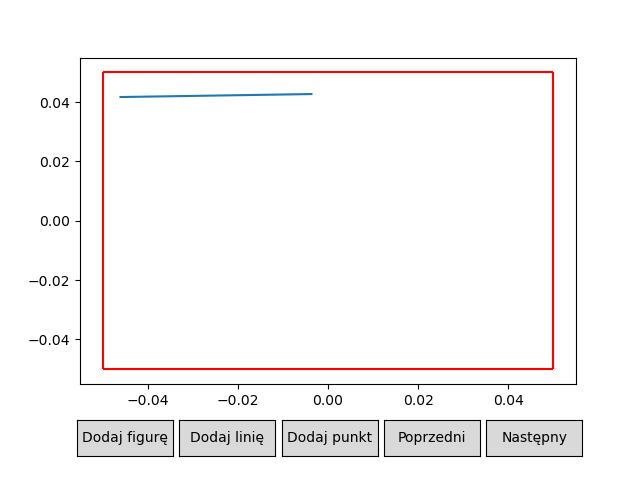

In [25]:
def visualize_creation_steps_plot():
    %matplotlib notebook
    global CREATE_SCENE_SET
    print(len(CREATE_SCENE_SET))
    scenes = [s.generate_normal_scene() for s in CREATE_SCENE_SET]
    plot = Plot(scenes)
    return plot

v_plot = visualize_creation_steps_plot()
v_plot.draw()